# Lab | Random Forests

For this lab, you will be using the .CSV files provided in the files_for_lab folder. These are cleaned versions of the learningSet data from the Case Study 'Healthcare for All'.
Begin a new Jupyter Notebook after Forking and Cloning this Repo.

Instructions

Apply the Random Forests algorithm but this time only by upscaling the data to deal with the imbalance.
Use Feature Selections that you have learned in class to decide if you want to use all of the features (Variance Threshold, RFE, PCA, etc.)

Re-run the Random Forest algorithm to determine if the Feature Selection has improved the results.
Discuss the output and its impact in the business scenario. Is the cost of a false positive equals to the cost of the false negative? How would you change your algorithm or data in order to maximize the return of the business?

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


numerical = pd.read_csv('numerical.csv')
categorical = pd.read_csv('categorical.csv')
targets = pd.read_csv('target.csv')
data = pd.concat([numerical, categorical, targets], axis = 1)
data['TARGET_B'].value_counts()

0    90569
1     4843
Name: TARGET_B, dtype: int64

# feature selection

In [2]:
data = data[['WEALTH2', 'POP90C5', 'ETH7', 'AGE906', 'CHILC2','HHN1', 'DW4', 'HV1','HV3', 'HHD11', 'ETHC4','HVP2', 'HVP3', 'HUPA6','ADI', 'IC1', 'IC4', 'IC12', 'IC22', 'HHAS3', 'MC1', 'MC2', 'PEC1', 'TPE11', 'TPE13', 'LFC3', 'LFC8', 'OCC13', 'EIC3', 'EIC4', 'EIC12', 'EIC13', 'EIC15', 'EC2', 'EC5', 'ANC8', 'HC6', 'HC16', 'CONTROLN', 'MAXRDATE_MM', 'TARGET_B', 'TARGET_D']]

In [3]:
data.head()

,WEALTH2,POP90C5,ETH7,AGE906,CHILC2,HHN1,DW4,HV1,HV3,HHD11,ETHC4,HVP2,HVP3,HUPA6,ADI,IC1,IC4,IC12,IC22,HHAS3,MC1,MC2,PEC1,TPE11,TPE13,LFC3,LFC8,OCC13,EIC3,EIC4,EIC12,EIC13,EIC15,EC2,EC5,ANC8,HC6,HC16,CONTROLN,MAXRDATE_MM,TARGET_B,TARGET_D
0,5,53,0,54,11,18,2,479,3,15,0,7,13,0,177.0,307,378,0,0,51,46,54,1,16,45,50,99,4,3,41,4,9,1,16,21,1,31,0,95515,2,0,0.0
1,9,50,2,45,16,4,0,5468,12,4,0,98,98,0,13.0,1088,1037,13,10,66,56,44,0,32,71,58,99,3,6,13,4,10,11,5,21,3,97,0,148535,12,0,0.0
2,1,51,0,49,14,21,6,497,2,17,0,1,6,3,281.0,251,340,0,0,31,38,62,1,24,61,59,82,7,11,33,0,7,3,22,16,0,50,15,15078,7,0,0.0
3,0,46,2,47,17,23,4,1000,2,12,0,25,50,0,67.0,386,423,0,0,26,46,54,0,15,43,53,0,0,6,3,0,3,3,28,27,0,39,16,172556,11,0,0.0
4,9,54,0,50,15,16,0,576,4,23,21,1,2,0,127.0,240,321,0,0,11,20,80,2,27,76,51,81,2,6,1,4,15,4,16,13,0,6,0,7112,1,0,0.0


In [4]:
data.isna().sum().sum()

0

In [5]:
y = data['TARGET_B']
X = data.drop(['TARGET_B', 'TARGET_D'], axis = 1)

numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(np.object)

# we OneHotEncode the categoricals so we can use the same dataset to perform a regression later (in the lab).
# it is not needed for a DecisionTree or RandomForest model-->no one hot encoding needed, but do for later
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first').fit(categoricalX)
encoded_categorical = encoder.transform(categoricalX).toarray()
encoded_categorical = pd.DataFrame(encoded_categorical)
X = pd.concat([numericalX, encoded_categorical], axis = 1)

# Note: we need to do train/test split before downsampling, and then only downsample the training set - Why?
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
trainset=pd.concat([y_train, X_train ], axis=1)

In [7]:
from sklearn.utils import resample

category_0 = trainset[trainset['TARGET_B'] == 0]
category_1 = trainset[trainset['TARGET_B'] == 1]

In [8]:
category_1_oversampled = resample(category_1, 
                                  replace=True, 
                                  n_samples = len(category_0))
print(category_0.shape)
print(category_1_oversampled.shape)

(72486, 41)
(72486, 41)


In [9]:
data_upsampled = pd.concat([category_0, category_1_oversampled], axis=0)

In [10]:
X_train_upsampled = data_upsampled.drop(columns=['TARGET_B'])
y_train_upsampled = data_upsampled['TARGET_B']

In [11]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.8,
                             random_state = 42)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

0.9496521636599458
0.9475973379447676


0    18083
1     1000
Name: TARGET_B, dtype: int64

array([[18083,     0],
       [ 1000,     0]], dtype=int64)

In [13]:
# For cross validation
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(np.mean(cross_val_scores))

0.9496521640971386


In [14]:
cross_val_scores

array([0.94969213, 0.94969213, 0.94969213, 0.94969213, 0.94969213,
       0.94969213, 0.94956112, 0.94956112, 0.94956112, 0.94968553])

In [15]:
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
X_added_constant = sm.add_constant(X_train_upsampled)
X_added_constant
model = sm.OLS(y_train_upsampled,X_added_constant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TARGET_B   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     32.67
Date:                Fri, 07 Apr 2023   Prob (F-statistic):          6.80e-247
Time:                        12:14:27   Log-Likelihood:            -1.0457e+05
No. Observations:              144972   AIC:                         2.092e+05
Df Residuals:                  144931   BIC:                         2.096e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4388      0.016     27.471      0.000       0.408       0.470
WEALTH2        -0.0048      0.001     -9.533      0.000      -0.006      -0.004
POP90C5        -0.0028      0.001     -4.735      0.000      -0.004      -0.002
ETH7            0.0001      0.001      0.225      0.822      -0.001       0.001
AGE906          0.0043      0.001      8.089      0.000       0.003       0.005
CHILC2          0.0024      0.000      5.635      0.000       0.002       0.003
HHN1           -0.0008      0.000     -2.344      0.019      -0.002      -0.000
DW4            -0.0005      0.000     -3.677      0.000      -0.001      -0.000
HV1          2.302e-05   3.56e-06      6.475      0.000    1.61e-05       3e-05
HV3            -0.0009      0.001     -0.795      0.427      -0.003       0.001
HHD11           0.0018      0.000      3.822      0.000       0.001       0.003
ETHC4          -0.0038      0.000     -9.834      0.000      -0.005      -0.003
HVP2           -0.0002      0.000     -1.374      0.169      -0.000    7.63e-05
HVP3            0.0003   9.66e-05      3.170      0.002       0.000       0.000
HUPA6       -8.387e-05      0.000     -0.484      0.628      -0.000       0.000
ADI         -9.503e-06    1.2e-05     -0.794      0.427    -3.3e-05     1.4e-05
IC1         -2.253e-05   2.87e-05     -0.786      0.432   -7.87e-05    3.36e-05
IC4             0.0001   3.11e-05      3.994      0.000    6.32e-05       0.000
IC12           -0.0055      0.001     -8.378      0.000      -0.007      -0.004
IC22           -0.0005      0.001     -0.632      0.527      -0.002       0.001
HHAS3          -0.0002      0.000     -1.427      0.154      -0.001    8.31e-05
MC1            -0.0004      0.000     -0.972      0.331      -0.001       0.000
MC2            -0.0010      0.000     -2.380      0.017      -0.002      -0.000
PEC1            0.0005      0.000      2.179      0.029     4.6e-05       0.001
TPE11          -0.0006      0.000     -2.238      0.025      -0.001   -8.02e-05
TPE13        -6.49e-06      0.000     -0.063      0.950      -0.000       0.000
LFC3            0.0005      0.000      2.812      0.005       0.000       0.001
LFC8         4.374e-05   4.59e-05      0.952      0.341   -4.63e-05       0.000
OCC13          -0.0030      0.001     -5.586      0.000      -0.004      -0.002
EIC3            0.0002      0.000      0.506      0.613      -0.001       0.001
EIC4        -1.131e-05      0.000     -0.071      0.944      -0.000       0.000
EIC12          -0.0008      0.001     -1.388      0.165      -0.002       0.000
EIC13          -0.0002      0.000     -0.771      0.441      -0.001       0.000
EIC15          -0.0019      0.000     -4.969      0.000      -0.003      -0.001
EC2            -0.0007      0.000     -2.925      0.003      -0.001      -0.000
EC5         -4.259e-06      0.000     -0.01

In [16]:
rfc = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.2,
                             random_state = 42)
rfc.fit(X_train_upsampled, y_train_upsampled)
print(rfc.score(X_train_upsampled,y_train_upsampled))
print(rfc.score(X_test,y_test))
# Make predictions on the test data
y_pred = rfc.predict(X_test)

0.5905002345280468
0.5859141644395536


# variance threshold

In [17]:
vt = VarianceThreshold(threshold=0.05)
X_vt = vt.fit_transform(X_train_upsampled)
scores_vt = cross_val_score(rfc, X_vt, y_train_upsampled, cv=5, scoring='accuracy')
scores_vt.mean()

0.5899966985100163

In [18]:
vt = VarianceThreshold(threshold=0.1)
X_vt = vt.fit_transform(X_train_upsampled)
scores_vt = cross_val_score(rfc, X_vt, y_train_upsampled, cv=5, scoring='accuracy')
scores_vt.mean()

0.5899966985100163

In [19]:
vt = VarianceThreshold(threshold=0.05)
X_vt = vt.fit_transform(X_train_upsampled)
scores_vt = cross_val_score(rfc, X_vt, y_train_upsampled, cv=10, scoring='accuracy')
scores_vt.mean()

0.5886585536893753

# PCA

In [20]:
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.5498440967556981

In [21]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.5615774046905757

In [22]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.5649159936438675

In [23]:
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.569303019481717

In [24]:
pca = PCA(n_components=9)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.5730899692122231

In [25]:
pca = PCA(n_components=11)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.5810777367011599

In [26]:
pca = PCA(n_components=13)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.5838092949474547

In [27]:
pca = PCA(n_components=21)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.5895759220354954

# X and y upsampled

In [30]:
scores_ups = cross_val_score(rfc, X_train_upsampled, y_train_upsampled, cv=5, scoring='accuracy')
scores_ups.mean()

0.5899966985100163

In [31]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(max_depth=4)
regr.fit(X_train, y_train)
print("test data score was: ",regr.score(X_test, y_test))
print("train data score was: ",regr.score(X_train, y_train))

test data score was:  -0.0033698882981700873
train data score was:  0.0049208797977631225


In [32]:
max_depth = range(1,30)
test = []
train = []

for depth in max_depth:
    model = DecisionTreeRegressor(max_depth=depth, random_state=0)
    model.fit(X_train, y_train)
    test.append(model.score(X_test,y_test))
    train.append(model.score(X_train,y_train))

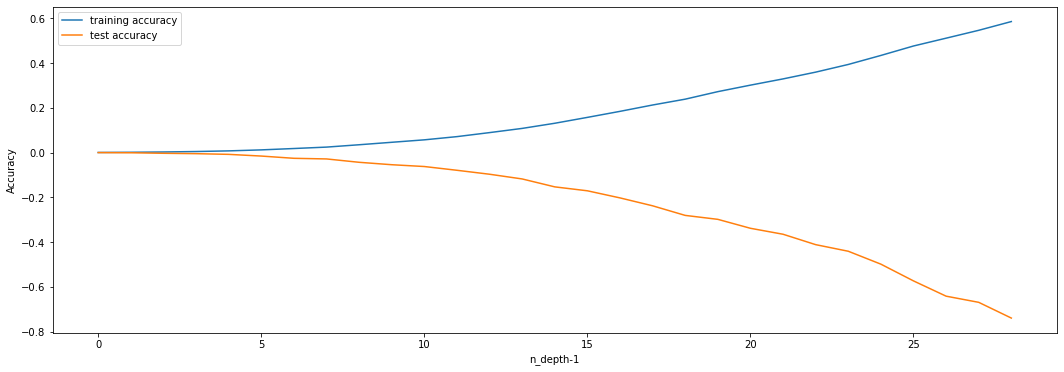

In [33]:
# we quickly see overfitting properties
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(18,6))
plt.plot( train, label="training accuracy")
plt.plot( test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth-1")
plt.legend()

In [ ]:
# with feature selection the score drops about 3%